# Laboratório 12: Reator Biológico

### Referente ao capítulo 19

Solo contaminado possui muitas vezes bactérias que são capazes de eliminar o contaminante. Então um método para limpar essas áreas é aumentar o nível dessas bactérias. A injeção de nutrientes necessárias para o metabolismo e crescimento da colônia provaram-se técnicas de sucesso no aumento da população de bactérias. Todavia essa modelagem é bem complexa, dada aos diversos fatores que se relacionam, 
Por esse motivo, uma configuração mais controlada é utilizada nesse laboratório, como encontramos no reatores biológicos. 

Consideraremos uma reator com mistura ideal onde bactéria $x(t)$ e contaminante  $z(t)$ se distribuem uniformemente (unidade g/L), e a bactéria degrada o contaminante. Seja $u(t)$ o nutriente que controlamos espacialmente uniforme. Assim 

$$
x'(t) = Gu(t)x(t) - Dx(t)^2, x(0) = x_0 > 0
$$

onde $G$ é a taxa máxima de crescimento e $D$ é a taxa de morte natural. A taxa de degradação do contaminante é proporcional à concentração de ambos, 

$$
z'(t) = -Kx(t)z(t), z(0) = z_0 > 0,
$$

onde $K$ é a taxa de degradação da bactéria. O solo tem limitações físicas e, portanto, $0 \le u(t) \le M$. O objetivo é minimizar o uso do nutriente e o nível final de contaminante:

$$
\ln(z(T)) + \int_0^T Au(t) dt, 
$$

Seja $A = 1$. Temos que 

$$
z(t) = z_0\exp\left(-\int_0^t Kx(s)ds\right), 
$$

de forma que 

$$
- \int_0^T Kx(s)ds = \ln\left(\frac{z(T)}{z_0}\right) = \ln(z(T)) - \ln(z_0)
$$

Assim podemos tirar $z(T)$ do nosso funcional objetivo. Além disso, $z_0$ não tem efeito na minimização e pode ser removido. Assim, nosso problema pode ser transformado em (invertendo o sinal transforma o problema em maximização): 

$$
\max_u \int_0^T Kx(t) - u(t) dt, 
$$
$$
\text{sujeito a   }x'(t) = Gu(t)x(t) - Dx^2(t), x(0) = x_0, 0 \le u(t) \le M
$$

Agora $K$ também tem papel de peso e, por isso, podíamos colocar $A = 1$. 

### Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

## Condições necessárias 

Mais uma vez vamos utilizar a biblioteca simbólica para nos ajudar nos cálculos. Note que esse sistema é tão simples que de fato não seria muito necessário, mas vamos usar assim mesmo. 

### Hamiltoniano

In [2]:
x, u, l, t, D, G, K = sp.symbols('x u lambda t D G K')
H = K*x - u + l*(G*u*x - D*x**2)
H

K*x + lambda*(-D*x**2 + G*u*x) - u

### Condições do Estado

In [3]:
print(sp.diff(H,l))

-D*x**2 + G*u*x


### Equaçãoes Adjuntas

In [4]:
dl = (-1)*sp.diff(H,x)
print(dl)

-K - lambda*(-2*D*x + G*u)


### Transversalidade 

$\lambda(T) = 0$

### Otimalidade

In [5]:
psi = sp.diff(H,u)
psi

G*lambda*x - 1

## Demonstração que o problema é Bang-Bang

$$
(x\lambda)' = x'\lambda + x\lambda ' = -Dx^2\lambda + Gux\lambda -Kx + 2Dx^2\lambda - Gux\lambda = Dx(x\lambda - K/D)
$$

Como $x = 0$ é um equilíbrio e $x(0) > 0$, vale que $x(t) > 0$ para todo $t$. Suponha que $(x\lambda)(t) < K/D$ para algum $t$. Assim $(x\lambda)'(t) < 0$ e a função decresce nesse ponto, isto é, ela permanecerá abaixo desse limiar. O mesmo vale para a desigualdade oposta ou igualdade. Portanto, para todo $t$, vale que essa expressão é $=, > \text{ ou } <$. Como $(x\lambda)(T) = 0 < K/D \implies (x\lambda)(t) < K/D$, para todo $t$. Portanto essa função é monotonicamente decrescente, então $G\lambda x = 1$ pode ser mantido em apenas 1 ponto.  

Conscluímos que $u^*$ é Bang-Bang com ponto de troca quando $G\lambda x - 1$ troca de sinal. 

## Aplicando a classe ao exemplo 

Vamos começar as experimentações. Podemos fazer uma função específica para plotar nesse exemplo. 

In [6]:
def plotting(t,x,z,u, fig = None, ax = None, label = ''): 
    
    if ax is None: 
        fig, ax = plt.subplots(3, sharex=True, figsize = (12,8))
        fig.suptitle('Comportamento das bactérias e do contaminante', fontsize = 18)
            
        ax[0].set_ylabel('Bactérias')
        ax[1].set_ylabel('Contaminante')
        ax[2].set_ylabel('Nutriente')
    
    ax[0].plot(t,x, label = label)
    ax[1].plot(t,z, label = label)
    ax[2].plot(t,u, label = label)
    
    return fig, ax

In [7]:
parameters = {'D': None, 'K': None, 'G': None, 'M': None}

diff_state = lambda t, x, u, par: -par['D']*x**2 + par['G']*u*x

diff_lambda = lambda t, x, u, lambda_, par: -par['K'] - lambda_*(-2*par['D']*x + par['G']*u)

update_u = lambda t, x, lambda_, par: 0.0 if par['G']*x*lambda_ < 1 else par['M']

In [8]:
problem = OptimalControl(diff_state, diff_lambda, update_u, 
                         n_controls = 1, n_states = 1)

In [9]:
x0 = 0.5
z0 = 0.1
T = 2
parameters['K'] = 2
parameters['G'] = 1
parameters['D'] = 1
parameters['M'] = 1

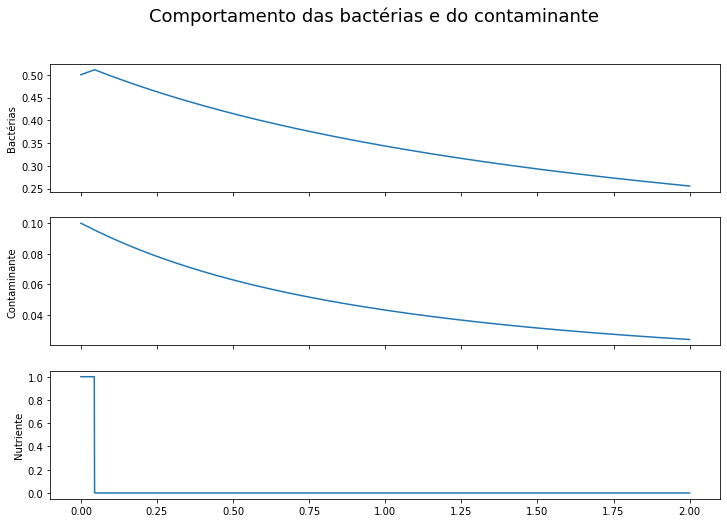

In [10]:
t,x,u,lambda_ = problem.solve(x0, T, parameters)

h = T/(len(x)-1)
z = z0*np.exp(-parameters['K']*h*np.cumsum(x))

ax = plotting(t, x, z, u)

A combinação dos valores de $K$ e $G$ não nos favorece a colocar nutriente no reator e, portanto, deixá-lo sem perturbação é melhor em quase todo o percurso. Isso diminui a população de bactérias rapidamente. Agora faremos uma pequena variação no parâmetro $K$. Observe que por muito mais tempo a injeção de nutrientes é mais eficiente, o que aumenta a população de bactérias o suficiente para reduzir muitoo o contaminante. 

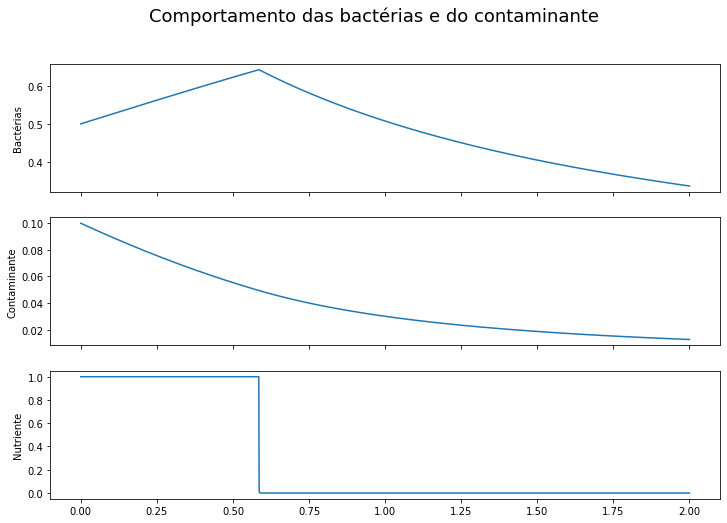

In [11]:
parameters['K'] = 2.1
t,x,u,lambda_ = problem.solve(x0, T, parameters)

h = T/(len(x)-1)
z = z0*np.exp(-parameters['K']*h*np.cumsum(x))

ax = plotting(t, x, z, u)

In [12]:
parameters['K'] = 2
G_values = [1, 1.2, 1.4] 
u_values = []
x_values = []
z_values = []
for G in G_values: 
    parameters['G'] = G
    _,x,u,_ = problem.solve(x0, T, parameters)
    u_values.append(u)
    x_values.append(x)
    z = z0*np.exp(-parameters['K']*h*np.cumsum(x))
    z_values.append(z)

Percebemos que quanto maior o valor de $G$, maior a injeção de nutrientes. Isso faz sentido, pois o valor de $u(t)$ fica mais tempo nesse valor máximo. Outro ponto interessante é que o ganho por aumentar em 0.2 diminui no decréscimo de contaminante. 

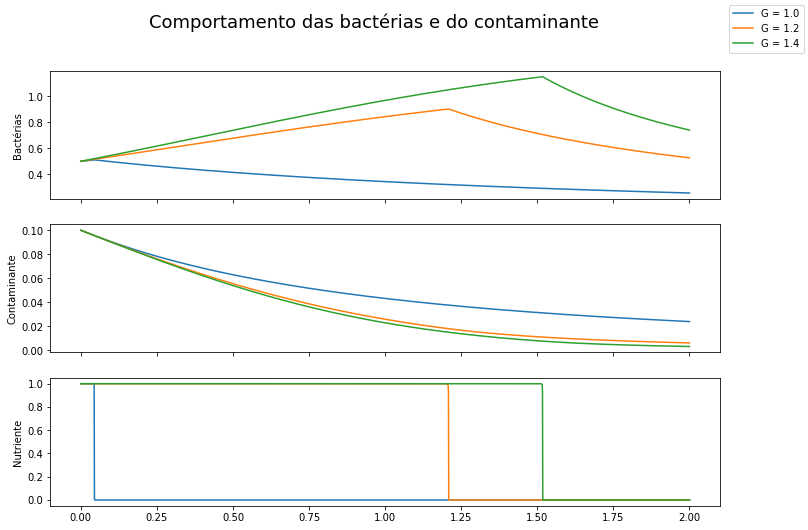

In [13]:
fig, ax = plotting(t, x_values[0], z_values[0], u_values[0], label = 'G = 1.0')
plotting(t, x_values[1], z_values[1], u_values[1], ax = ax, label = 'G = 1.2')
plotting(t, x_values[2], z_values[2], u_values[2], ax = ax, label = 'G = 1.4')

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels)

plt.show()

In [14]:
parameters['G'] = 1.2
x0_values = [0.3, 0.5, 0.7] 
u_values = []
x_values = []
z_values = []
for x0 in x0_values: 
    _,x,u,_ = problem.solve(x0, T, parameters)
    u_values.append(u)
    x_values.append(x)
    z = z0*np.exp(-parameters['K']*h*np.cumsum(x))
    z_values.append(z)

Agora vamos ver o que a condição inicial de bactérias causa no sistema. Esperamos que quanto maior o índice de bactérias, menor a necessidade de aumentar a injeção de nutrientes para reduzir a quantidade do contaminante. Mas na verdade o oposto acontece. Isso ocorre, pois a população de bactérias cresce e degrada o contaminante exponencialmente. Assim, com mais bactérias, a degradação se dá mais rápido e ainda vale a pena aumentar o número de bactérias. No caso em que $x_0 = 0.3$, a quantidade é tão pequena que deixar o sistema decair sozinho é a melhor estratégia. 

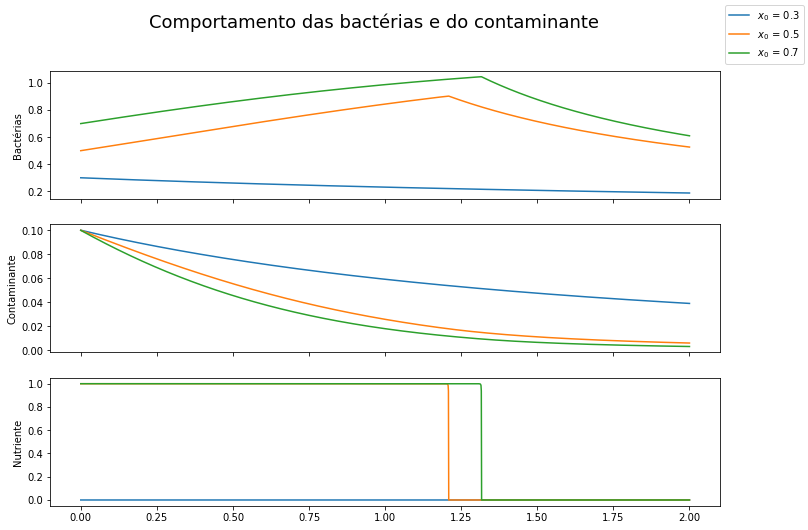

In [15]:
fig, ax = plotting(t, x_values[0], z_values[0], u_values[0], label = r'$x_0$ = 0.3')
plotting(t, x_values[1], z_values[1], u_values[1], ax = ax, label = r'$x_0$ = 0.5')
plotting(t, x_values[2], z_values[2], u_values[2], ax = ax, label = r'$x_0$ = 0.7')

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels)

plt.show()

Por fim, vamos verificar o que $M$ faz no sistema. 

In [16]:
x0 = 0.5 
M_values = [0.5, 1.0, 2.0] 
u_values = []
x_values = []
z_values = []
for M in M_values: 
    parameters['M'] = M
    _,x,u,_ = problem.solve(x0, T, parameters)
    u_values.append(u)
    x_values.append(x)
    z = z0*np.exp(-parameters['K']*h*np.cumsum(x))
    z_values.append(z)

Por mais contraditório que pareça, quanto maior o valor de $M$, por mais tempo a injeção de nutrientes ocorre. Isso novamente se deve ao caráter exponencial das populações. 

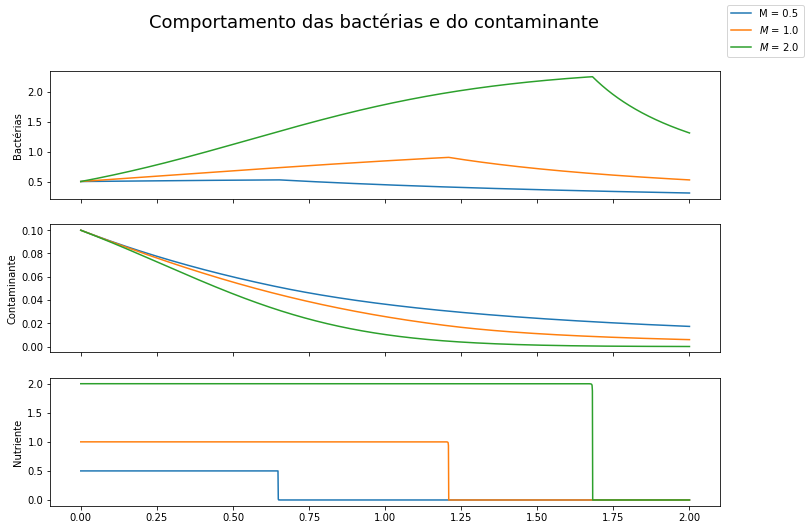

In [17]:
fig, ax = plotting(t, x_values[0], z_values[0], u_values[0], label = r'M = 0.5')
plotting(t, x_values[1], z_values[1], u_values[1], ax = ax, label = r'$M$ = 1.0')
plotting(t, x_values[2], z_values[2], u_values[2], ax = ax, label = r'$M$ = 2.0')

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels)

plt.show()

### Este é o final do notebook